In [1]:
import numpy as np
import pandas as pd

# 2. Generate a synthetic time-series dataset for daily inventory demand
num_days = 1000

# Base demand
base_demand = 100

# Seasonal component (e.g., annual cycle)
seasonality_amplitude = 30
seasonality_period = 365.25 # Approximately one year
seasonality = seasonality_amplitude * np.sin(np.arange(num_days) * (2 * np.pi / seasonality_period))

# Random noise
noise_amplitude = 15
noise = np.random.normal(0, noise_amplitude, num_days)

# Trend component (optional, but good for realism)
trend = np.linspace(0, 0.1 * num_days, num_days)

# Combine components to get total demand
demand = np.maximum(0, base_demand + seasonality + noise + trend).astype(int)

# 3. Create a pandas DataFrame
dates = pd.date_range(start='2020-01-01', periods=num_days, freq='D')
df_inventory = pd.DataFrame({'Date': dates, 'Demand': demand})

# 4. Display the first few rows and summary statistics
print("First 5 rows of the inventory demand dataset:")
print(df_inventory.head())

print("\nSummary statistics of the inventory demand dataset:")
print(df_inventory.describe())

First 5 rows of the inventory demand dataset:
        Date  Demand
0 2020-01-01      75
1 2020-01-02     129
2 2020-01-03      95
3 2020-01-04     106
4 2020-01-05      99

Summary statistics of the inventory demand dataset:
                      Date       Demand
count                 1000  1000.000000
mean   2021-05-14 12:00:00   151.458000
min    2020-01-01 00:00:00    57.000000
25%    2020-09-06 18:00:00   124.750000
50%    2021-05-14 12:00:00   149.000000
75%    2022-01-19 06:00:00   177.000000
max    2022-09-26 00:00:00   248.000000
std                    NaN    37.000882


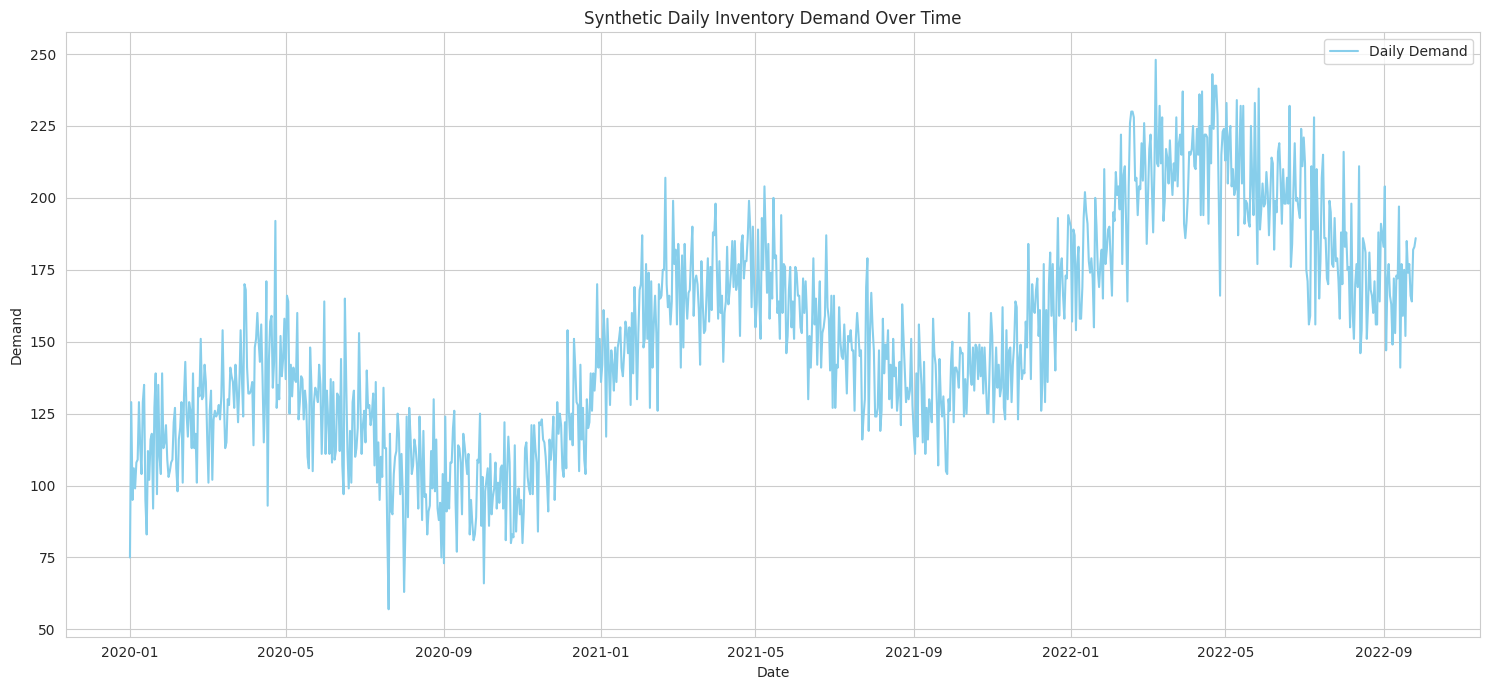

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plot the synthetic demand data
plt.figure(figsize=(15, 7))
plt.plot(df_inventory['Date'], df_inventory['Demand'], label='Daily Demand', color='skyblue')
plt.title('Synthetic Daily Inventory Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.tight_layout()
plt.show()


## Preprocess Data for LSTM


In [3]:
from sklearn.preprocessing import MinMaxScaler

# 1. Extract the 'Demand' column and reshape
data = df_inventory['Demand'].values.reshape(-1, 1)

# 2. Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 3. Define a look_back window
look_back = 30 # For example, use the past 30 days to predict the next day

# 4. Create a function to generate sequences (X, y)
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, look_back)

# 5. Split the generated X and y into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# Reshape input to be [samples, time steps, features] for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

print("Data preprocessing complete: extracted, scaled, sequenced, and split into training/testing sets.")

Shape of X_train: (776, 30, 1)
Shape of y_train: (776,)
Shape of X_test: (194, 30, 1)
Shape of y_test: (194,)
Data preprocessing complete: extracted, scaled, sequenced, and split into training/testing sets.


## Build and Train LSTM Model


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 1. Define the LSTM model architecture
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# 2. Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display model summary
print("Model Summary:")
model.summary()

# 3. Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

print("LSTM model built and trained successfully.")

Model Summary:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0861 - val_loss: 0.0425
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0127 - val_loss: 0.0275
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0097 - val_loss: 0.0123
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0096 - val_loss: 0.0089
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0098 - val_loss: 0.0119
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0081 - val_loss: 0.0127
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0083 - val_loss: 0.0107
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0081 - val_loss: 0.0071
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0079 - val_loss: 0.0071
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step
Test RMSE: 17.543


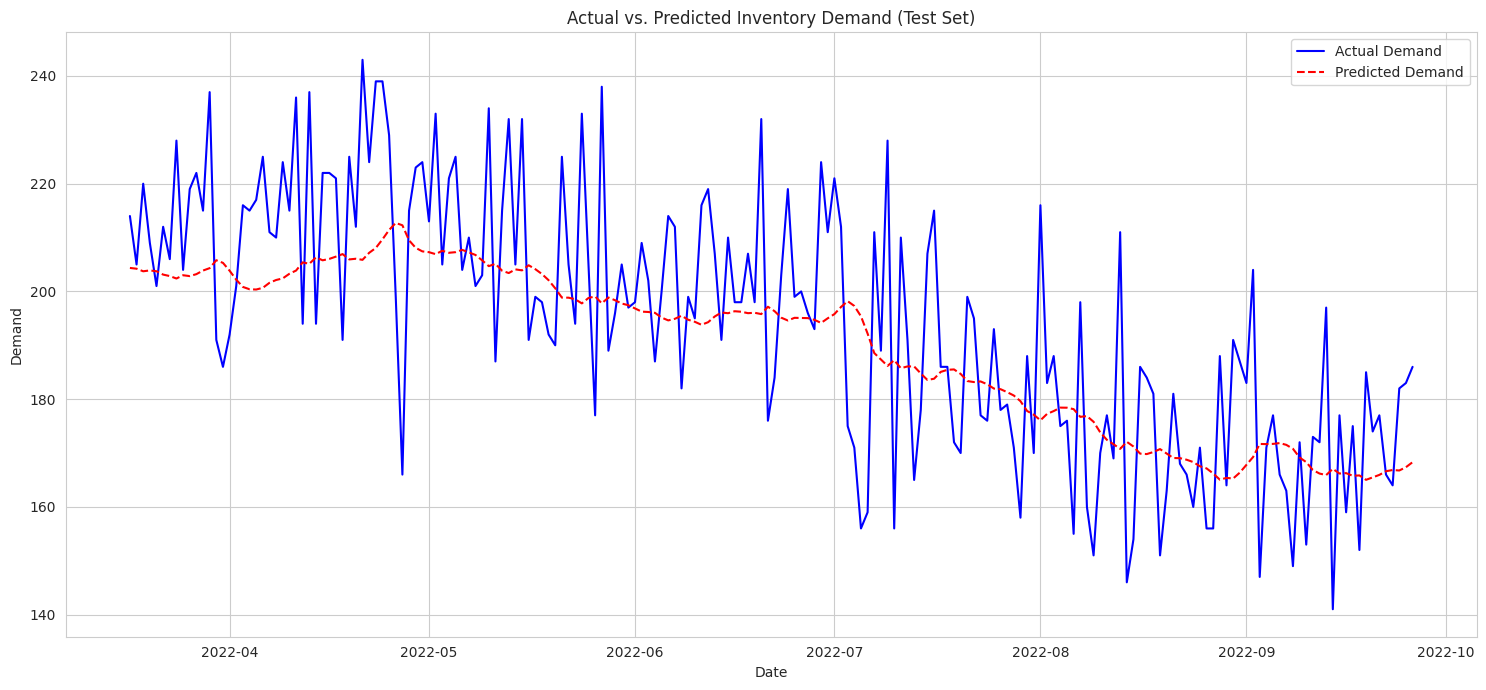

Model evaluation complete. RMSE calculated and predictions visualized.


In [7]:
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Make predictions on the test dataset
test_predict = model.predict(X_test)

# 2. Inverse transform the predictions and actual values
test_predict_inverse = scaler.inverse_transform(test_predict)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# 3. Calculate Root Mean Squared Error (RMSE)
rmse = math.sqrt(mean_squared_error(y_test_inverse, test_predict_inverse))
print(f"Test RMSE: {rmse:.3f}")

# 4. Plot the actual vs. predicted values
sns.set_style("whitegrid")
plt.figure(figsize=(15, 7))

# Adjusting the dates for the plot to correspond to the test set
# The original df_inventory has 1000 days.
# look_back days are used for sequence creation, so len(df_inventory) - look_back = 970 total sequences.
# train_size is 80% of sequences, so X_train covers indices 0 to 775.
# X_test starts from index 776.
# The actual dates for y_test start from index (train_size + look_back) in the original df_inventory.
# Or more simply, for the plot, we can align the prediction indices with the y_test indices.

# Calculate the starting index for the dates corresponding to y_test
start_index_for_y_test_dates = len(df_inventory) - len(y_test_inverse)

dates_for_plot = df_inventory['Date'][start_index_for_y_test_dates:].reset_index(drop=True)

plt.plot(dates_for_plot, y_test_inverse, label='Actual Demand', color='blue')
plt.plot(dates_for_plot, test_predict_inverse, label='Predicted Demand', color='red', linestyle='--')
plt.title('Actual vs. Predicted Inventory Demand (Test Set)')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.tight_layout()
plt.show()

print("Model evaluation complete. RMSE calculated and predictions visualized.")


In [8]:
import pickle

# Define a filename for the trained LSTM model object with a .pkl extension
model_object_filename = 'lstm_inventory_model_object.pkl'

# Use pickle.dump() to serialize the model object directly into the specified .pkl file
with open(model_object_filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Trained LSTM model object saved as {model_object_filename}")

Trained LSTM model object saved as lstm_inventory_model_object.pkl
